2/2 [==============================] - 0s 51ms/step
Metrics for 28_05_07.png:
  F1 Score: 0.7781 | mIoU: 0.6368 | Precision: 0.9466 | Recall: 0.6605



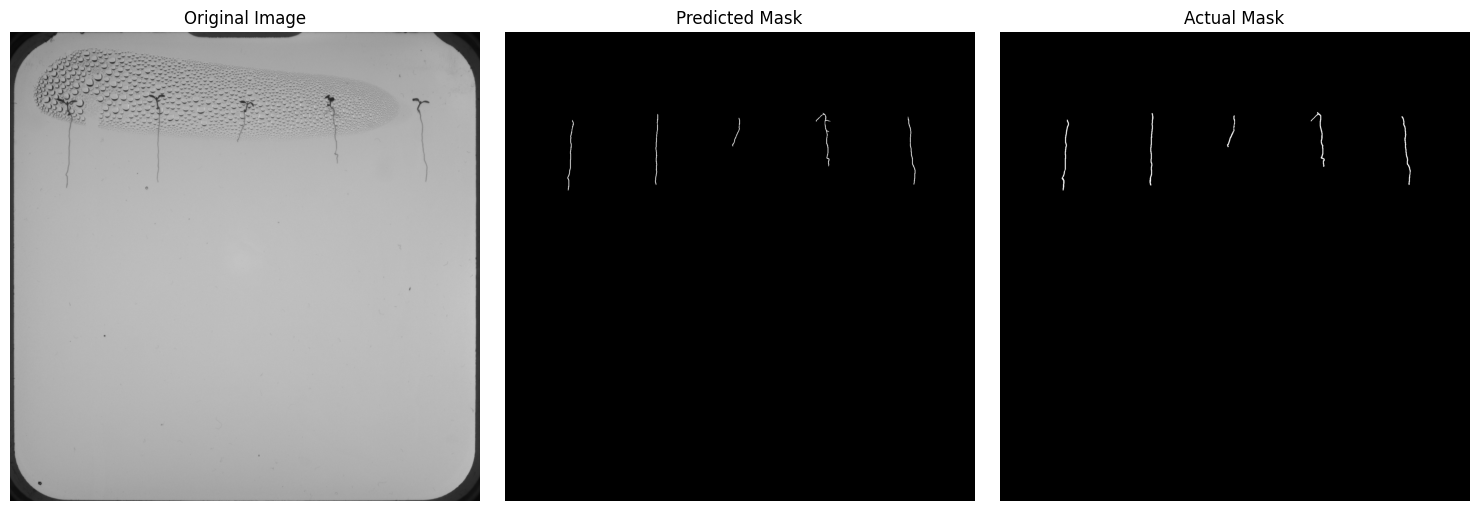

2/2 [==============================] - 0s 81ms/step
Metrics for 28_05_10.png:
  F1 Score: 0.7794 | mIoU: 0.6386 | Precision: 0.9037 | Recall: 0.6852



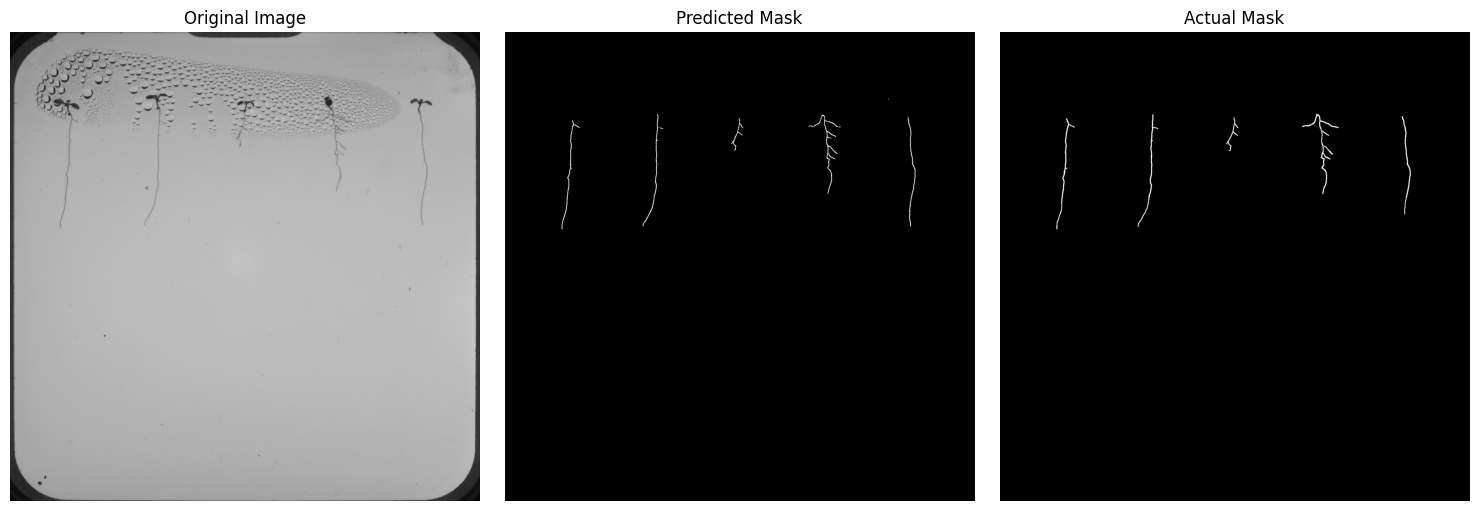

2/2 [==============================] - 0s 79ms/step
Metrics for 28_05_02.png:
  F1 Score: 0.7296 | mIoU: 0.5743 | Precision: 0.9125 | Recall: 0.6078



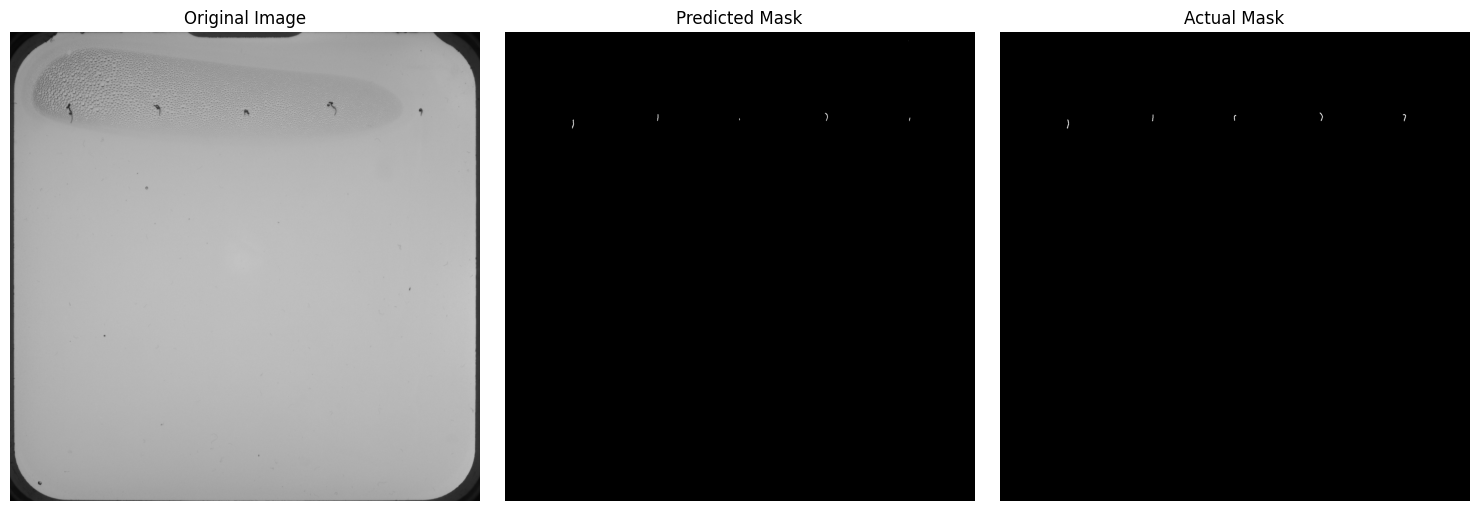

2/2 [==============================] - 0s 81ms/step
Metrics for 28_05_05.png:
  F1 Score: 0.7801 | mIoU: 0.6395 | Precision: 0.9636 | Recall: 0.6554



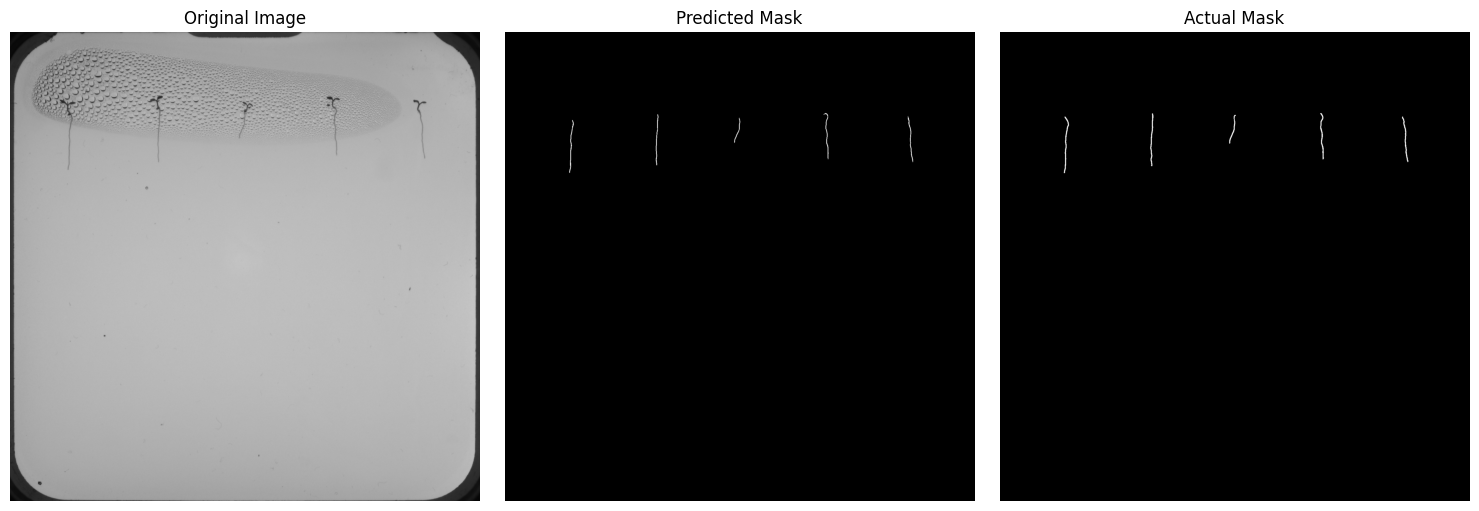

2/2 [==============================] - 0s 85ms/step
Metrics for 28_05_08.png:
  F1 Score: 0.7926 | mIoU: 0.6565 | Precision: 0.9363 | Recall: 0.6872



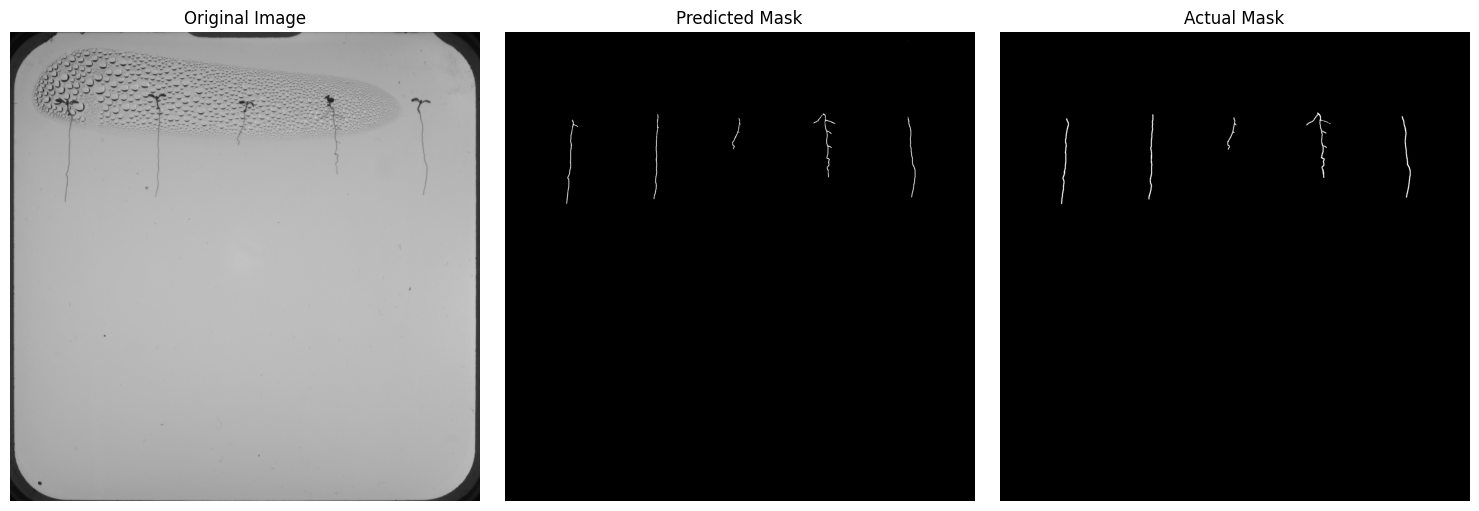

2/2 [==============================] - 0s 53ms/step
Metrics for 28_05_13.png:
  F1 Score: 0.7723 | mIoU: 0.6290 | Precision: 0.8948 | Recall: 0.6793



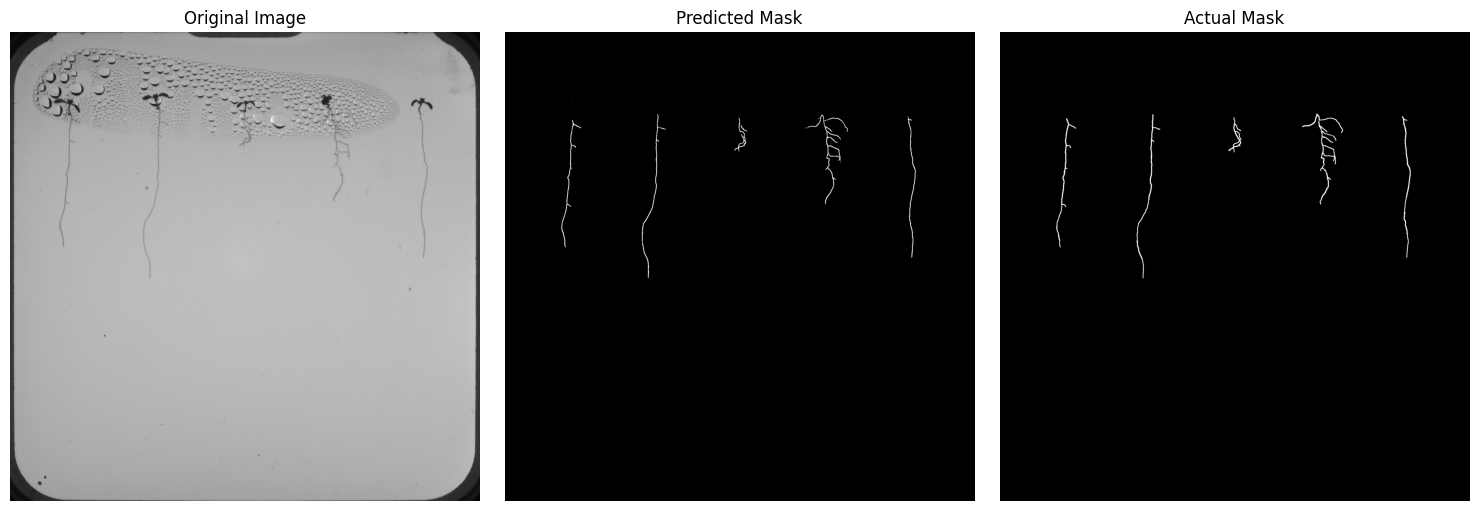

2/2 [==============================] - 0s 49ms/step
Metrics for 28_05_15.png:
  F1 Score: 0.7633 | mIoU: 0.6171 | Precision: 0.8849 | Recall: 0.6710



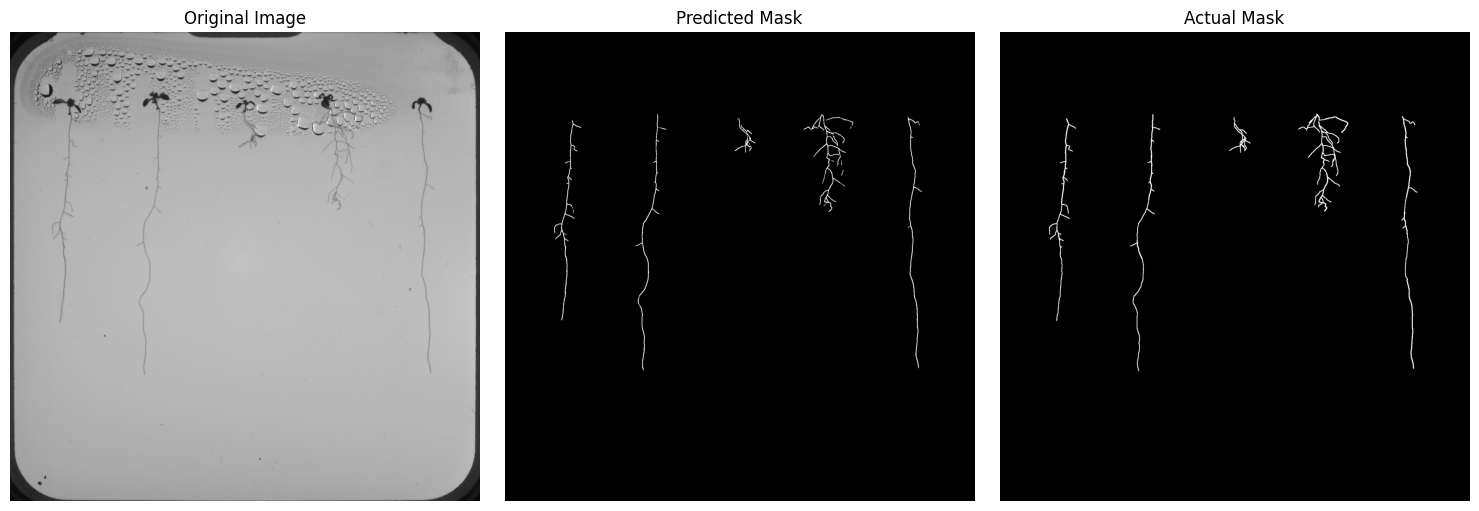

2/2 [==============================] - 0s 79ms/step
Metrics for 28_05_04.png:
  F1 Score: 0.7867 | mIoU: 0.6485 | Precision: 0.9706 | Recall: 0.6614



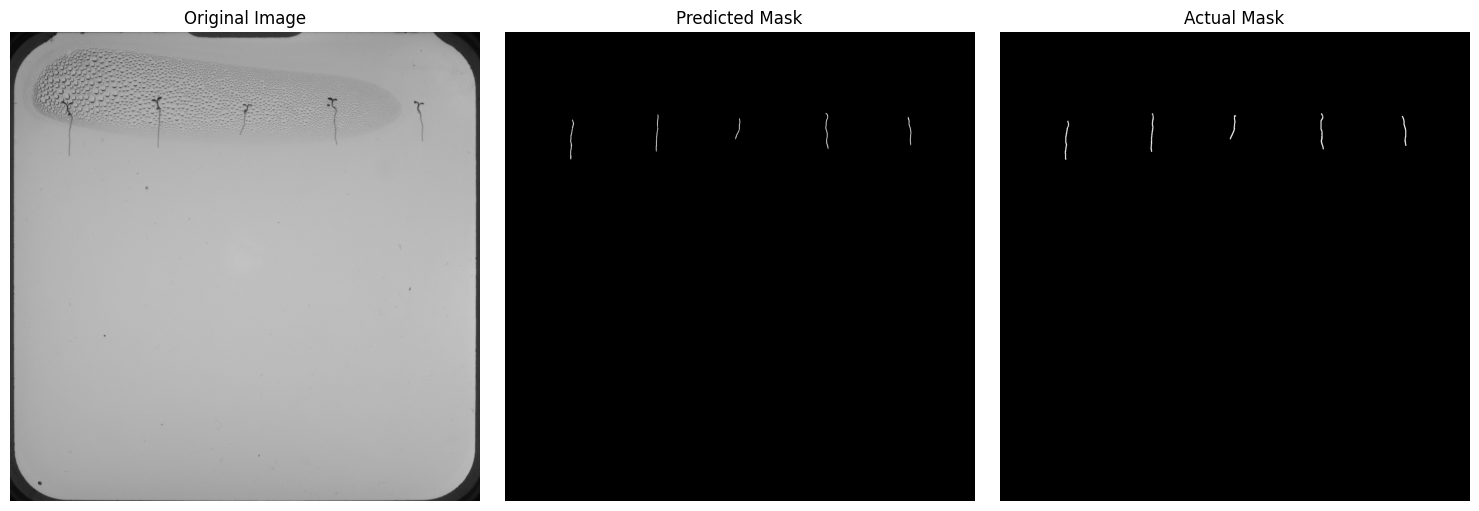

2/2 [==============================] - 0s 50ms/step
Metrics for 28_05_12.png:
  F1 Score: 0.7685 | mIoU: 0.6241 | Precision: 0.9051 | Recall: 0.6678



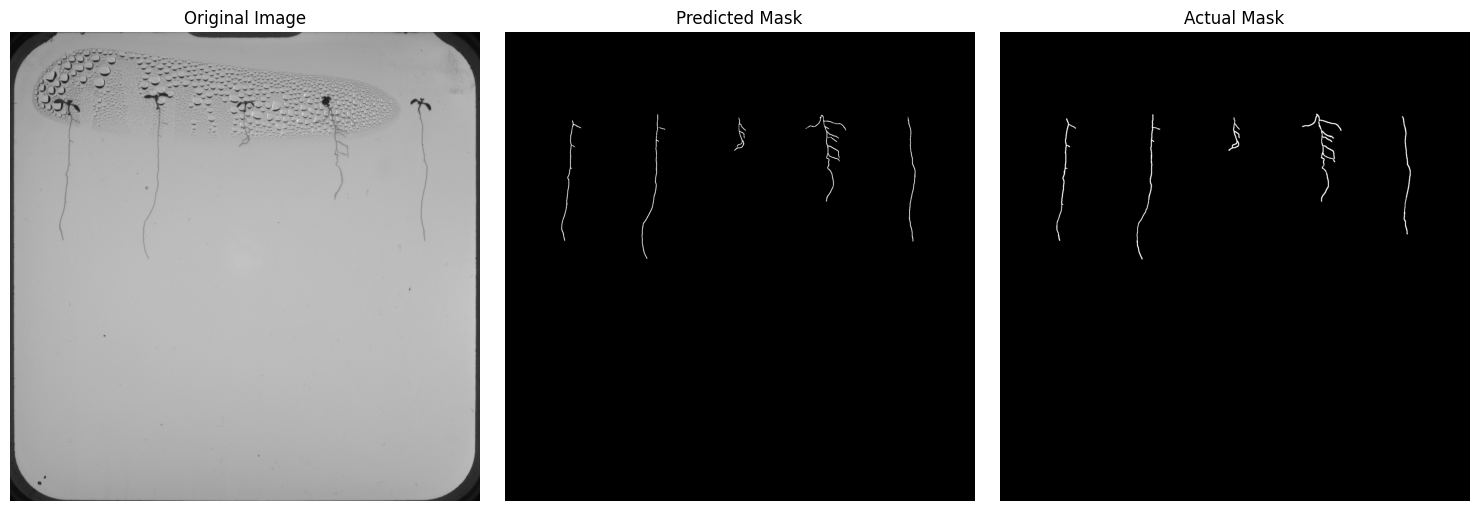

2/2 [==============================] - 0s 45ms/step
Metrics for 28_05_03.png:
  F1 Score: 0.8032 | mIoU: 0.6712 | Precision: 0.9185 | Recall: 0.7137



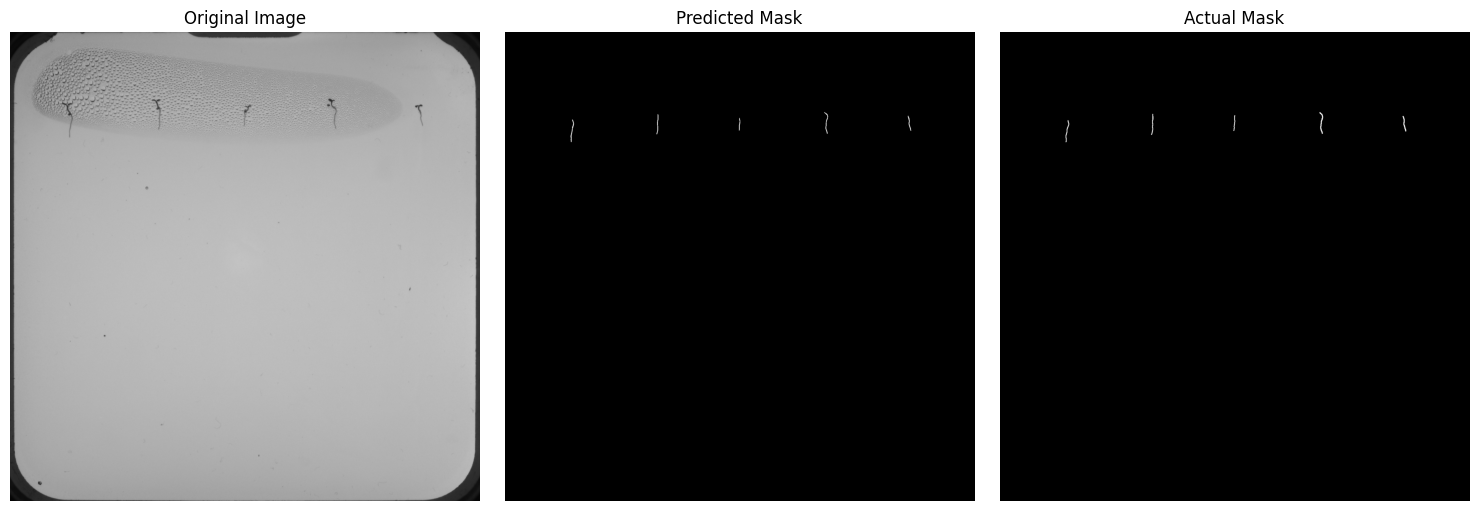

2/2 [==============================] - 0s 78ms/step
Metrics for 28_05_09.png:
  F1 Score: 0.7854 | mIoU: 0.6466 | Precision: 0.9017 | Recall: 0.6957



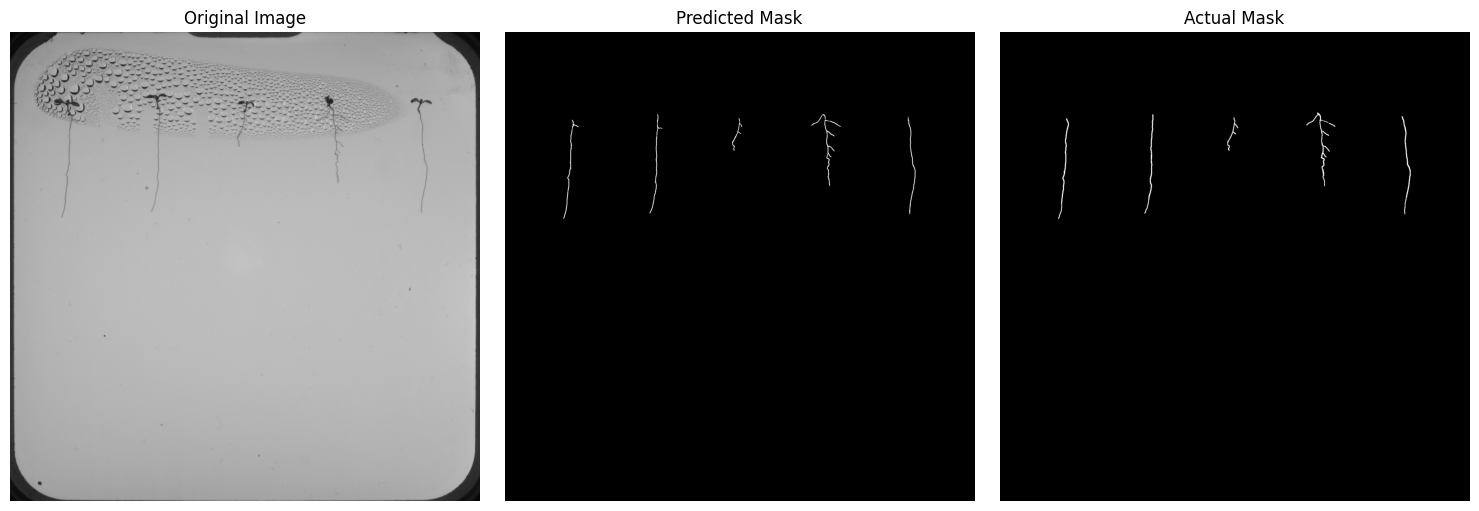

2/2 [==============================] - 0s 58ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_cla

Metrics for 28_05_01.png:
  F1 Score: 0.0000 | mIoU: 0.0000 | Precision: 0.0000 | Recall: 0.0000



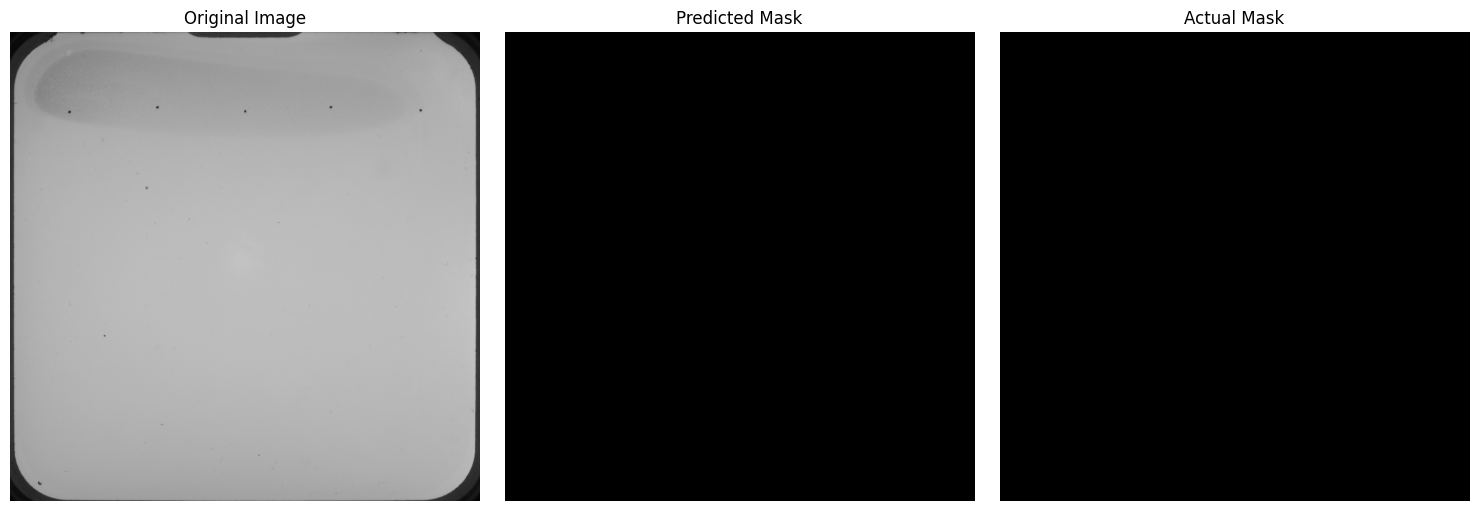

2/2 [==============================] - 0s 53ms/step
Metrics for 28_05_06.png:
  F1 Score: 0.7713 | mIoU: 0.6278 | Precision: 0.9401 | Recall: 0.6539



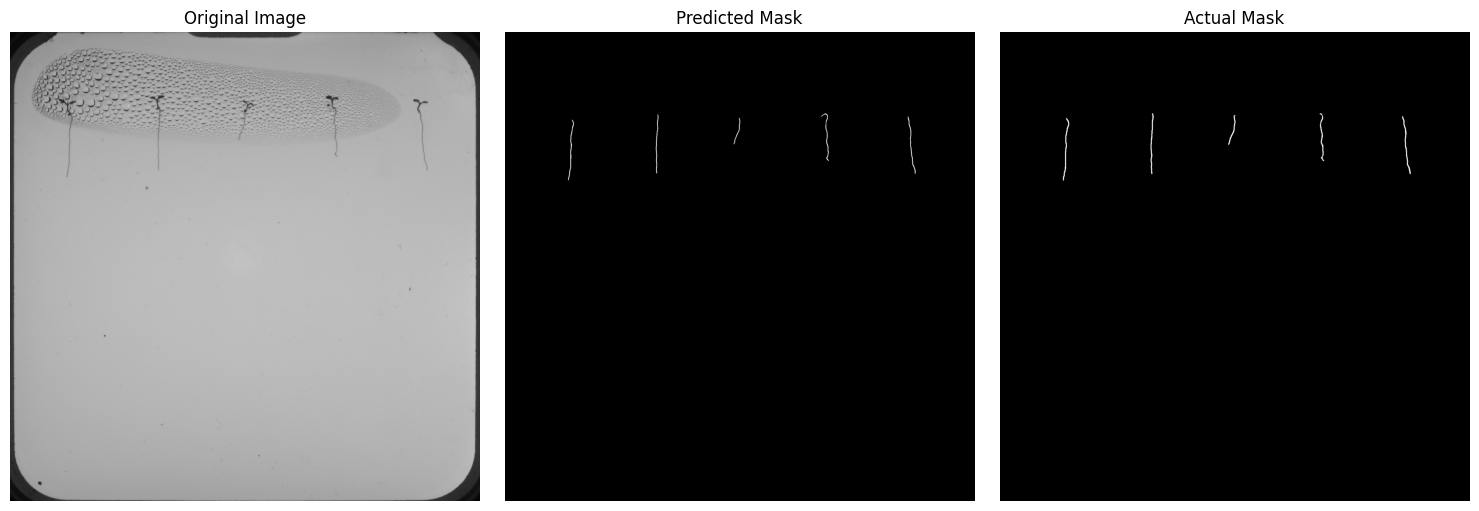

2/2 [==============================] - 0s 53ms/step
Metrics for 28_05_14.png:
  F1 Score: 0.7517 | mIoU: 0.6022 | Precision: 0.8770 | Recall: 0.6577



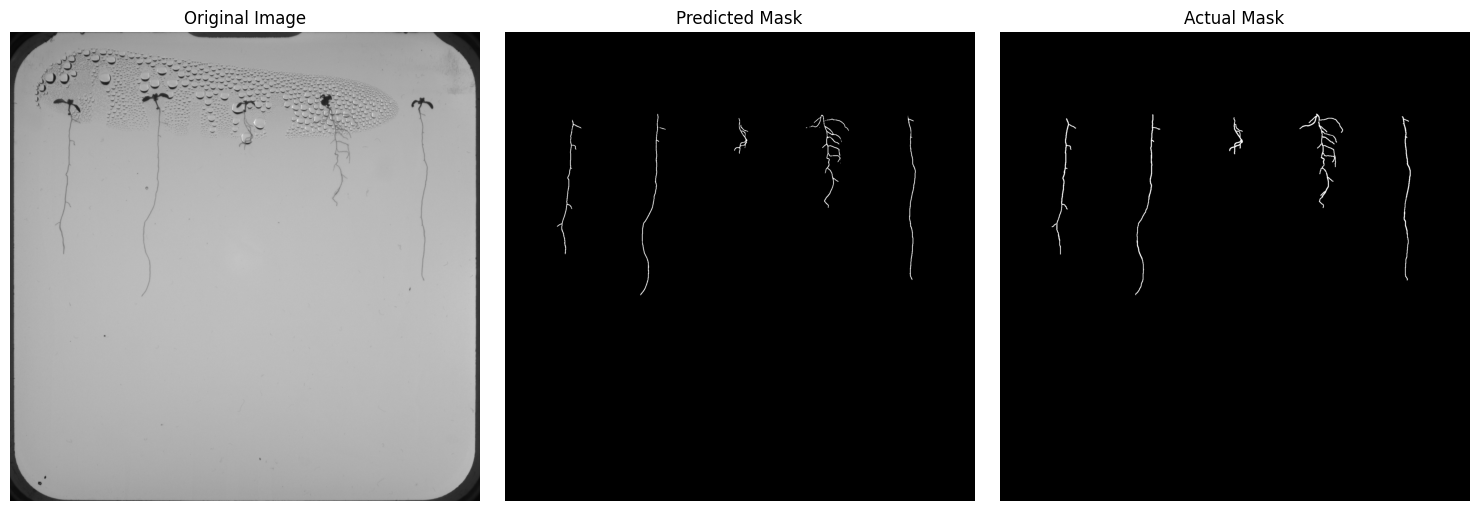

2/2 [==============================] - 0s 75ms/step
Metrics for 28_05_11.png:
  F1 Score: 0.7873 | mIoU: 0.6492 | Precision: 0.9212 | Recall: 0.6874



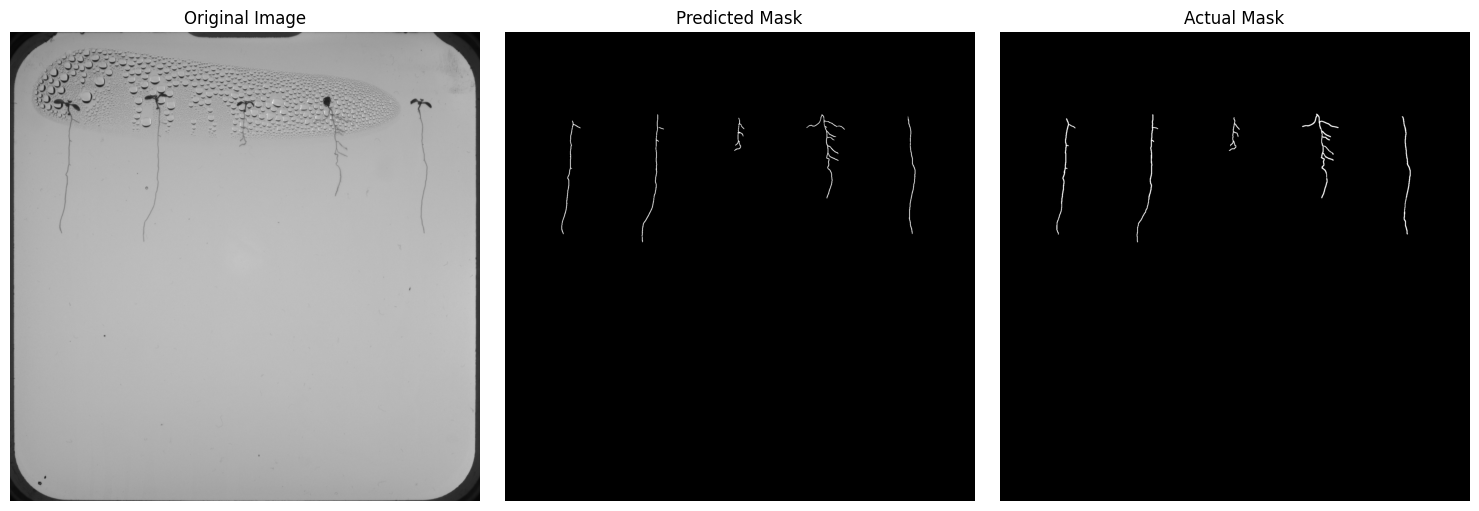

=== Average Metrics ===
Avg F1 Score: 0.7233
Avg mIoU: 0.5908
Avg Precision: 0.8584
Avg Recall: 0.6256


In [29]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def pipeline(image_dir, kernel_size=5, patch_size=256):
    model_path = "unet_model.h5"
    model = load_model(model_path, custom_objects={"f1": f1})

    all_f1 = []
    all_iou = []
    all_precision = []
    all_recall = []

    # Assume masks are in a 'masks' subfolder inside image_dir, with matching filenames
    mask_dir = image_dir

    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            # Read and preprocess image
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)  # grayscale
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
            image_np = image_color / 255.0

            # Pad and patchify
            image_padded = padder(image_np, patch_size=patch_size)
            patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size)
            expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
            patches = patches.reshape(-1, patch_size, patch_size, 3)

            # Predict patches and unpatchify
            predicted_patches = model.predict(patches)
            predicted_patches = predicted_patches.reshape(expected_shape[0], expected_shape[1], patch_size, patch_size, predicted_patches.shape[-1])
            predicted_patches = predicted_patches[:, :, :, :, 0]
            prediction = unpatchify(predicted_patches, image_padded.shape[:2])

            # Threshold prediction to get binary mask
            prediction_bool = (prediction > 0.5).astype(np.uint8)

            # Load the actual mask and preprocess it to match prediction size
            mask_path = os.path.join(mask_dir, file).replace('.png', '.tif')
            if not os.path.exists(mask_path):
                print(f"Mask for {file} not found, skipping...")
                continue
            mask = cv2.imread(mask_path, 0)  # grayscale mask
            mask = crop_to_coordinates(mask, stats, centroids)
            mask = padder(mask, patch_size=patch_size)
            mask_bool = (mask > 0.5).astype(np.uint8)
            
            # Flatten masks for metrics
            pred_flat = prediction_bool.flatten()
            mask_flat = mask_bool.flatten()

            # Calculate metrics
            f1_val = f1_metric(mask_flat, pred_flat)
            iou_val = jaccard_score(mask_flat, pred_flat)
            precision_val = precision_score(mask_flat, pred_flat)
            recall_val = recall_score(mask_flat, pred_flat)

            # Store metrics
            all_f1.append(f1_val)
            all_iou.append(iou_val)
            all_precision.append(precision_val)
            all_recall.append(recall_val)

            print(f"Metrics for {file}:")
            print(f"  F1 Score: {f1_val:.4f} | mIoU: {iou_val:.4f} | Precision: {precision_val:.4f} | Recall: {recall_val:.4f}\n")

            # Plot side-by-side: original image, predicted mask, actual mask
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(image_np)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(prediction_bool, cmap='gray')
            axs[1].set_title("Predicted Mask")
            axs[1].axis("off")

            axs[2].imshow(mask_bool, cmap='gray')
            axs[2].set_title("Actual Mask")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

    # After processing all images, print average metrics
    if all_f1:
        print("=== Average Metrics ===")
        print(f"Avg F1 Score: {np.mean(all_f1):.4f}")
        print(f"Avg mIoU: {np.mean(all_iou):.4f}")
        print(f"Avg Precision: {np.mean(all_precision):.4f}")
        print(f"Avg Recall: {np.mean(all_recall):.4f}")
    else:
        print("No valid images/masks were processed.")

# Example usage
df = pipeline('data_v1_unprocessed/test')